In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import cross_validation
from sklearn import metrics
from sklearn import feature_selection
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from imblearn import over_sampling
from imblearn import combine
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
numpy.random.seed(1337)

In [4]:
def print_full(column):
    pandas.set_option('display.max_rows', len(column))
    pandas.set_option('display.max_columns', 10000)
    print(column)
    pandas.reset_option('display.max_rows')
    pandas.reset_option('display.max_columns')

Importing the data

In [5]:
MasterPBA = pandas.read_csv("MasterPBA_Clean.csv")

C:\Users\john.wang\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (28,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Indicating the response for supervised learning techniques and dropping excessive columns

In [6]:
print_full(MasterPBA.isnull().sum())

Unnamed: 0                             0
bid id                                 0
LN ID                                  0
OriginMarket                           0
DestMarket                             0
AverageOTRMiles                        0
AverageOTRRate                         0
AverageIMLRate                         0
AverageIMLMiles                        0
O City                                 0
D City                                 0
Awarded Y/N                            0
Target MPU                           114
Dray Reduced                           0
Floor Win %                          783
Expert Win %                         783
Expert MPU                           114
Floor MPU                            774
VOL                                    1
Total Rate                             0
Original RPM                           0
Target Win %                         783
With Comp                              0
With Truck                             0
% With Comp     

In [7]:
MasterPBA = MasterPBA.drop(["Unnamed: 0","bid id", "LN ID", "OriginMarket", "DestMarket", "AverageOTRMiles", 
                            "AverageIMLMiles", "O City", "D City", "VOL", "Total Rate", "O ST", "D ST", "D Zip", "Miles", 
                            "O Ramp", "O MKT Ramp", "D MKT Ramp", "D Ramp", "PKU", "LHL", "DEL", "Lease/REZ", "Total Cost", 
                            "Fee", "Current TPS Rate", "Rate Status", "Hub Fuel Cost @ Analysis Level 1", 
                            "Cust Fuel @ Analysis Level 1", "Fuel Build In 1", "Cust Fuel Rate 1", "Cust Fuel Type 1 (PM/RP)", 
                            "DOE 1", "ODR Miles", "DDR Miles", "Haz Flag", "Price Cust #", "fuelpct", "fndr", "AVG_OTR_STPAIR", 
                            "CUSTOMER_NAME", "CUSTOMER_NUMBER", "DATE_AWARD_START", "runDt", "STPAIR", "Ramp", "Market", 
                            "Awarded Volume", "Symbol", "EQ Type", "With Comp", "With Truck"], axis=1)
#"Target MPU", "Floor Win %", "Expert Win %", "Expert MPU", "Floor MPU", "Target Win %", "Scope", "Floor Margin %", "Target Margin %", "Expert Margin %"
MasterPBA = MasterPBA.dropna()
Awarded = pandas.DataFrame(MasterPBA["Awarded Y/N"])
Awarded.columns = ["Awarded"]
MasterPBA = MasterPBA.drop(["Awarded Y/N"],axis=1)

In [7]:
print MasterPBA.columns.values

['AverageOTRRate' 'AverageIMLRate' 'Target MPU' 'Dray Reduced'
 'Floor Win %' 'Expert Win %' 'Expert MPU' 'Floor MPU' 'Original RPM'
 'Target Win %' '% With Comp' '% With Truck' 'Scope' 'Segment'
 'Method Used' 'Floor Margin %' 'Target Margin %' 'Expert Margin %'
 'Prior 6 mos Annualized' 'fuelnormed' 'Network' 'IS_REPRICE'
 'CHANGE_VOLUME' 'Past_Awarded' 'Lane' 'CorridorVolume' 'Public'
 'BNumberofComps' 'BAverageCompRate' 'BStDevofCompRates'
 'BAverageHubRevenue_Comp' 'BAverageHubCost' 'BAverageMiles']


Converting Categorical Variables into Labels. A dummy variable version is also created but may introduce too much dimensionality into the models.

In [8]:
MasterPBA_Dummies = pandas.get_dummies(MasterPBA)

LE = preprocessing.LabelEncoder()

for i in range(0,len(MasterPBA.columns.values)):
    if MasterPBA.dtypes[i] == "object":
        temp = MasterPBA.columns.values[i]
        LE.fit(MasterPBA[temp].unique())
        MasterPBA[temp] = LE.transform(MasterPBA[temp])

LE.fit(Awarded['Awarded'].unique())
Awarded['Awarded'] = LE.transform(Awarded['Awarded'])

print MasterPBA_Dummies

       AverageOTRRate  AverageIMLRate  Target MPU  Dray Reduced  Floor Win %  \
0            1.235000        0.676038       324.0     -0.110286          1.0   
1            1.235000        0.676038       324.0     -0.110286          1.0   
2            1.211333        0.616173       304.0     -0.136443          1.0   
3            1.211333        0.616173       304.0     -0.136443          1.0   
4            1.211333        0.616173       289.0     -0.100793          1.0   
5            1.211333        0.616173       289.0     -0.100793          1.0   
6            1.211333        0.616173       328.0     -0.195178          1.0   
7            1.211333        0.616173       328.0     -0.195178          1.0   
8            1.211333        0.616173       290.0     -0.102207          1.0   
9            1.211333        0.616173       290.0     -0.102207          1.0   
10           1.211333        0.616173       290.0     -0.103982          1.0   
11           1.211333        0.616173   

Creating the training and test sets

In [9]:
# MasterPBA = numpy.reshape(MasterPBA, (len(MasterPBA),len(MasterPBA.columns)))
MasterPBA_Dummies = numpy.reshape(MasterPBA_Dummies, (len(MasterPBA_Dummies),len(MasterPBA_Dummies.columns)))
Awarded = numpy.ravel(Awarded)

x_train, x_test, y_train, y_test = cross_validation.train_test_split(MasterPBA_Dummies, Awarded, test_size=.3333)


Rebalancing the data set by oversampling

In [10]:
Smote = over_sampling.SMOTE()
x_train_S, y_train_S = Smote.fit_sample(x_train, y_train)
print x_train_S.shape, y_train_S.shape

SmoteTomek = combine.SMOTETomek()
x_train_ST, y_train_ST = SmoteTomek.fit_sample(x_train, y_train)
print x_train_ST.shape, y_train_ST.shape

# EasyEnsemble = ensemble.EasyEnsemble()
# x_train_EE, y_train_EE = EasyEnsemble.fit_sample(x_train, y_train)
# print x_train_EE.shape, y_train_EE.shape

(14870L, 7237L) (14870L,)
(14840L, 7237L) (14840L,)


Model Evaluation

In [11]:
def model_evaluation(y_test, y_predicted):
    print "Classification Report"
    print metrics.classification_report(y_test, y_predicted)

    print "Confusion Matrix"
    print metrics.confusion_matrix(y_test, y_predicted)

    print "ROC AUC Score"
    print metrics.roc_auc_score(y_test, y_predicted)

    x,y,_ = metrics.roc_curve(y_test, y_predicted)
    plt.figure()
    plt.plot(x,y)
    plt.title("ROC Curve")
    plt.show()

def Features(model):
    temp_df = pandas.DataFrame([pandas.Series(x_train.columns.values), pandas.Series(model.feature_importances_)]).transpose()
    temp_df.columns = ["Feature", "Importance"]
    print_full(temp_df[abs(temp_df["Importance"]) > temp_df["Importance"].quantile(q=0.99)].sort_values("Importance", ascending=False))
    print 

Dumb Classification Model

Dumb Classification Model
Classification Report


C:\Users\john.wang\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.90      1.00      0.94      3709
          1       0.00      0.00      0.00       432

avg / total       0.80      0.90      0.85      4141

Confusion Matrix
[[3709    0]
 [ 432    0]]
ROC AUC Score
0.5


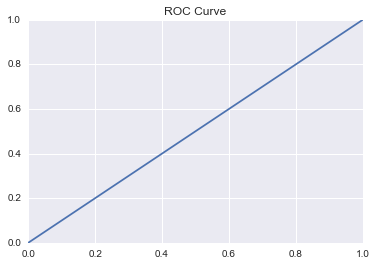

In [12]:
zero_count = 0
one_count = 0
for i in y_train:
    if i == 0:
        zero_count += 1
    else:
        one_count += 1

y_predicted = []
if zero_count > one_count:
    for i in range(0,len(y_test)):
        y_predicted.append(0)
else:
    for i in range(0,len(y_test)):
        y_predicted.append(1)
print "Dumb Classification Model"
model_evaluation(y_test, y_predicted)

Logistic Regression Model

Logistic Regression Model:
Classification Report
             precision    recall  f1-score   support

          0       0.92      0.99      0.95      3709
          1       0.69      0.24      0.36       432

avg / total       0.89      0.91      0.89      4141

Confusion Matrix
[[3663   46]
 [ 328  104]]
ROC AUC Score
0.61416923799


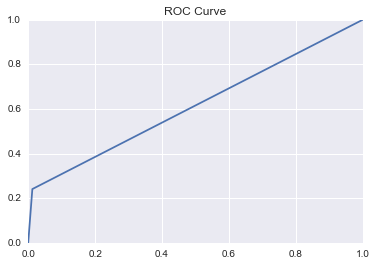

Logistic Regression Model SMOTE:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.93      0.95      3709
          1       0.54      0.76      0.63       432

avg / total       0.93      0.91      0.91      4141

Confusion Matrix
[[3434  275]
 [ 104  328]]
ROC AUC Score
0.842557642571


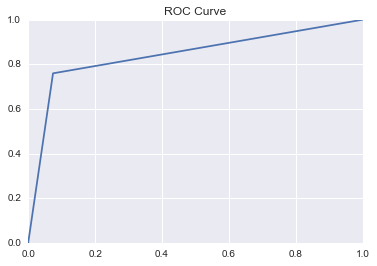

Logistic Regression Model SMOTETomek:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.92      0.94      3709
          1       0.51      0.74      0.60       432

avg / total       0.92      0.90      0.91      4141

Confusion Matrix
[[3396  313]
 [ 111  321]]
ROC AUC Score
0.829333116144


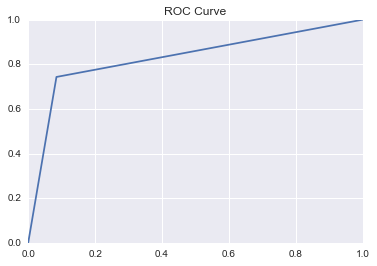

In [13]:
Log_Regression =  linear_model.LogisticRegression()
Log_Regression.fit(x_train, y_train)
print "Logistic Regression Model:"
model_evaluation(y_test, Log_Regression.predict(x_test))

Log_Regression.fit(x_train_S,y_train_S)
print "Logistic Regression Model SMOTE:"
model_evaluation(y_test, Log_Regression.predict(x_test))

Log_Regression.fit(x_train_ST,y_train_ST)
print "Logistic Regression Model SMOTETomek:"
model_evaluation(y_test, Log_Regression.predict(x_test))

# Log_Regression.fit(x_train_EE,y_train_EE)
# print "Logistic Regression Model EE:"
# model_evaluation(y_test, Log_Regression.predict(x_test))

Linear Discriminant Analysis Model

C:\Users\john.wang\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Linear Discriminant Analysis Model:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.77      0.86      3709
          1       0.28      0.79      0.42       432

avg / total       0.90      0.77      0.81      4141

Confusion Matrix
[[2851  858]
 [  90  342]]
ROC AUC Score
0.780168733711


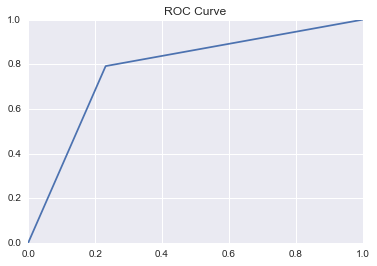

Linear Discriminant Analysis Model SMOTE:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.76      0.85      3709
          1       0.28      0.80      0.41       432

avg / total       0.90      0.76      0.80      4141

Confusion Matrix
[[2808  901]
 [  86  346]]
ROC AUC Score
0.779001652637


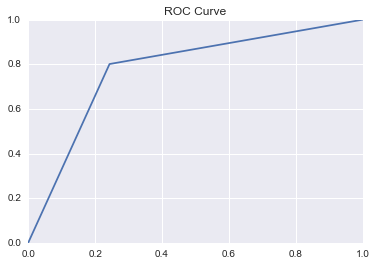

Linear Discriminant Analysis Model SMOTETomek:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.75      0.85      3709
          1       0.27      0.80      0.41       432

avg / total       0.90      0.76      0.80      4141

Confusion Matrix
[[2798  911]
 [  88  344]]
ROC AUC Score
0.775338765565


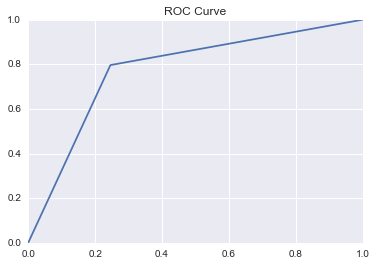

In [14]:
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(x_train, y_train)
print "Linear Discriminant Analysis Model:"
model_evaluation(y_test, LDA.predict(x_test))

LDA.fit(x_train_S, y_train_S)
print "Linear Discriminant Analysis Model SMOTE:"
model_evaluation(y_test, LDA.predict(x_test))

LDA.fit(x_train_ST, y_train_ST)
print "Linear Discriminant Analysis Model SMOTETomek:"
model_evaluation(y_test, LDA.predict(x_test))

# LDA.fit(x_train_EE, y_train_EE)
# print "Linear Discriminant Analysis Model EE:"
# model_evaluation(y_test, LDA.predict(x_test))

Naive Bayes Model

Naive Bayes Model:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.76      0.85      3709
          1       0.28      0.81      0.42       432

avg / total       0.90      0.77      0.81      4141

Confusion Matrix
[[2823  886]
 [  80  352]]
ROC AUC Score
0.787968205466


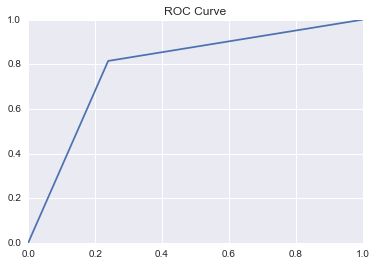

Naive Bayes Model SMOTE:
Classification Report
             precision    recall  f1-score   support

          0       0.99      0.26      0.41      3709
          1       0.13      0.97      0.23       432

avg / total       0.90      0.33      0.39      4141

Confusion Matrix
[[ 962 2747]
 [  11  421]]
ROC AUC Score
0.61695306961


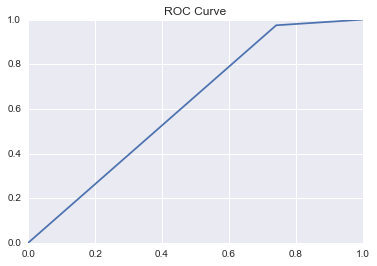

Naive Bayes Model SMOTETomek:
Classification Report
             precision    recall  f1-score   support

          0       0.99      0.25      0.41      3709
          1       0.13      0.97      0.23       432

avg / total       0.90      0.33      0.39      4141

Confusion Matrix
[[ 945 2764]
 [  11  421]]
ROC AUC Score
0.614661346774


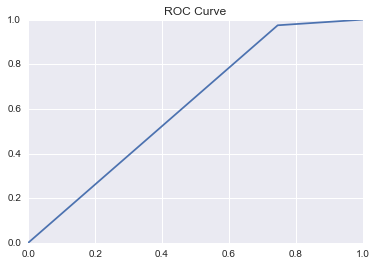

In [15]:
Naive_Bayes = naive_bayes.GaussianNB()
Naive_Bayes.fit(x_train, y_train)
print "Naive Bayes Model:"
model_evaluation(y_test, Naive_Bayes.predict(x_test))

Naive_Bayes.fit(x_train_S, y_train_S)
print "Naive Bayes Model SMOTE:"
model_evaluation(y_test, Naive_Bayes.predict(x_test))

Naive_Bayes.fit(x_train_ST, y_train_ST)
print "Naive Bayes Model SMOTETomek:"
model_evaluation(y_test, Naive_Bayes.predict(x_test))

# Naive_Bayes.fit(x_train_EE, y_train_EE)
# print "Naive Bayes Model EE:"
# model_evaluation(y_test, Naive_Bayes.predict(x_test))

K Nearest Neighbor Model

K Nearest Neighbor Model:
Classification Report
             precision    recall  f1-score   support

          0       0.94      0.97      0.95      3709
          1       0.65      0.46      0.54       432

avg / total       0.91      0.92      0.91      4141

Confusion Matrix
[[3603  106]
 [ 234  198]]
ROC AUC Score
0.714877100746


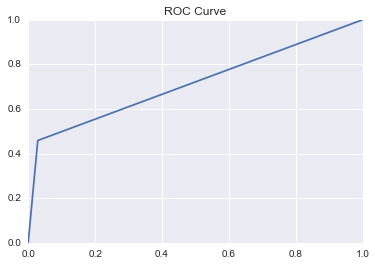

K Nearest Neighbor Model SMOTE:
Classification Report
             precision    recall  f1-score   support

          0       0.98      0.90      0.94      3709
          1       0.50      0.84      0.62       432

avg / total       0.93      0.89      0.91      4141

Confusion Matrix
[[3342  367]
 [  71  361]]
ROC AUC Score
0.868349822254


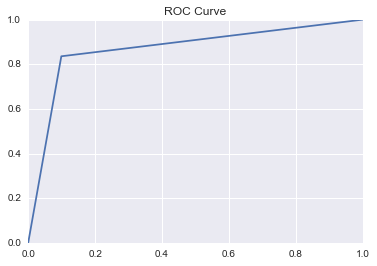

K Nearest Neighbor Model SMOTETomek:
Classification Report
             precision    recall  f1-score   support

          0       0.98      0.90      0.94      3709
          1       0.49      0.83      0.62       432

avg / total       0.93      0.89      0.90      4141

Confusion Matrix
[[3335  374]
 [  72  360]]
ROC AUC Score
0.866248764267


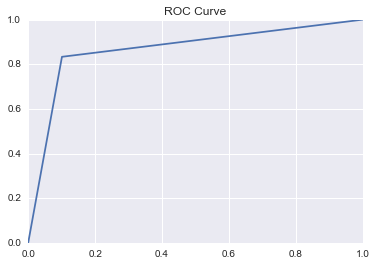

In [16]:
KNN = neighbors.KNeighborsClassifier()
KNN.fit(x_train, y_train)
print "K Nearest Neighbor Model:"
model_evaluation(y_test, KNN.predict(x_test))

KNN.fit(x_train_S, y_train_S)
print "K Nearest Neighbor Model SMOTE:"
model_evaluation(y_test, KNN.predict(x_test))

KNN.fit(x_train_ST, y_train_ST)
print "K Nearest Neighbor Model SMOTETomek:"
model_evaluation(y_test, KNN.predict(x_test))

# KNN.fit(x_train_EE, y_train_EE)
# print "K Nearest Neighbor Model EE:"
# model_evaluation(y_test, KNN.predict(x_test))

Decision Tree Model:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3709
          1       0.89      0.73      0.80       432

avg / total       0.96      0.96      0.96      4141

Confusion Matrix
[[3670   39]
 [ 117  315]]
ROC AUC Score
0.859325851532


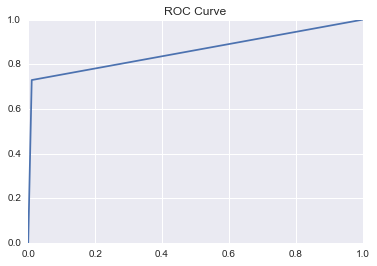

Decision Tree Model SMOTE:
Classification Report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      3709
          1       0.80      0.81      0.81       432

avg / total       0.96      0.96      0.96      4141

Confusion Matrix
[[3622   87]
 [  82  350]]
ROC AUC Score
0.89336436396


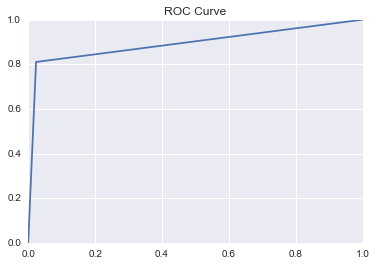

Decision Tree Model SMOTETomek:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      3709
          1       0.81      0.78      0.79       432

avg / total       0.96      0.96      0.96      4141

Confusion Matrix
[[3628   81]
 [  96  336]]
ROC AUC Score
0.87796950361


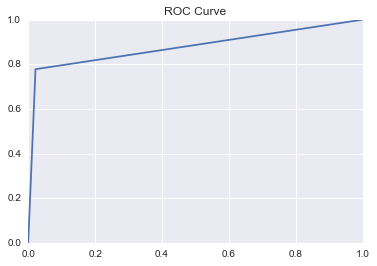

In [14]:
Decision_Tree = tree.DecisionTreeClassifier()
Decision_Tree.fit(x_train, y_train)
print "Decision Tree Model:"
model_evaluation(y_test, Decision_Tree.predict(x_test))

Decision_Tree2 = tree.DecisionTreeClassifier()
Decision_Tree2.fit(x_train_S, y_train_S)
print "Decision Tree Model SMOTE:"
model_evaluation(y_test, Decision_Tree2.predict(x_test))

Decision_Tree3 = tree.DecisionTreeClassifier()
Decision_Tree3.fit(x_train_ST, y_train_ST)
print "Decision Tree Model SMOTETomek:"
model_evaluation(y_test, Decision_Tree3.predict(x_test))

# Decision_Tree4 = tree.DecisionTreeClassifier()
# Decision_Tree4.fit(x_train_EE, y_train_EE)
# print "Decision Tree Model EE:"
# model_evaluation(y_test, Decision_Tree4.predict(x_test))

Random Forest Model

Random Forest Model:
Classification Report
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      3709
          1       0.95      0.64      0.76       432

avg / total       0.96      0.96      0.95      4141

Confusion Matrix
[[3694   15]
 [ 157  275]]
ROC AUC Score
0.816264928652


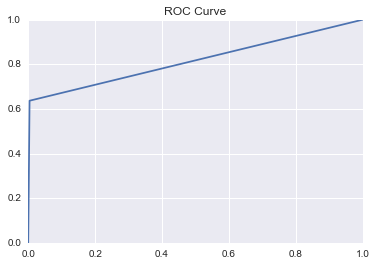

Random Forest Model SMOTE:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3709
          1       0.87      0.72      0.79       432

avg / total       0.96      0.96      0.96      4141

Confusion Matrix
[[3663   46]
 [ 121  311]]
ROC AUC Score
0.853752571323


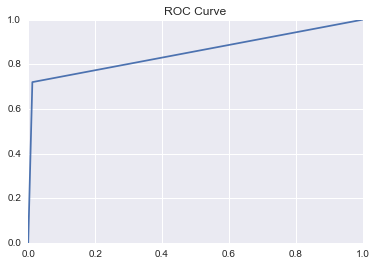

Random Forest Model SMOTETomek:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      3709
          1       0.85      0.70      0.77       432

avg / total       0.95      0.96      0.95      4141

Confusion Matrix
[[3657   52]
 [ 130  302]]
ROC AUC Score
0.842527061302


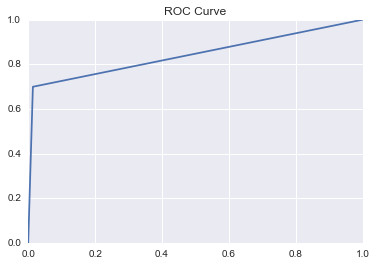

In [15]:
Random_Forest = ensemble.RandomForestClassifier()
Random_Forest.fit(x_train, y_train)
print "Random Forest Model:"
model_evaluation(y_test, Random_Forest.predict(x_test))

Random_Forest2 = ensemble.RandomForestClassifier()
Random_Forest2.fit(x_train_S, y_train_S)
print "Random Forest Model SMOTE:"
model_evaluation(y_test, Random_Forest2.predict(x_test))

Random_Forest3 = ensemble.RandomForestClassifier()
Random_Forest3.fit(x_train_ST, y_train_ST)
print "Random Forest Model SMOTETomek:"
model_evaluation(y_test, Random_Forest3.predict(x_test))

# Random_Forest4 = ensemble.RandomForestClassifier()
# Random_Forest4.fit(x_train_EE, y_train_EE)
# print "Random Forest Model EE:"
# model_evaluation(y_test, Random_Forest4.predict(x_test))

Bagging Decision Tree Model

Bagging Decision Tree Model:
Classification Report
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      3709
          1       0.92      0.61      0.73       432

avg / total       0.95      0.95      0.95      4141

Confusion Matrix
[[3686   23]
 [ 170  262]]
ROC AUC Score
0.80014017455


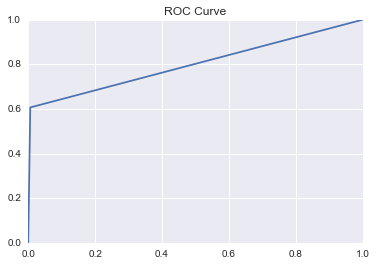

Bagging Decision Tree Model SMOTE:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      3709
          1       0.81      0.76      0.78       432

avg / total       0.96      0.96      0.96      4141

Confusion Matrix
[[3630   79]
 [ 103  329]]
ROC AUC Score
0.870137266209


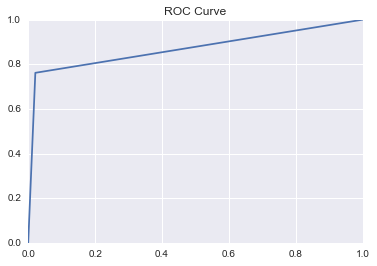

Bagging Decision Tree Model SMOTETomek:
Classification Report
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      3709
          1       0.82      0.75      0.79       432

avg / total       0.96      0.96      0.96      4141

Confusion Matrix
[[3637   72]
 [ 106  326]]
ROC AUC Score
0.867608694567


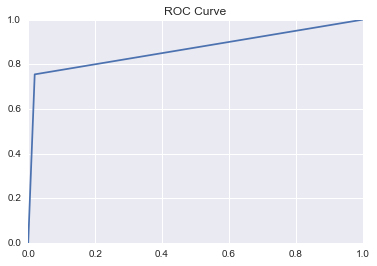

In [ ]:
Bagging = ensemble.BaggingClassifier()
Bagging.fit(x_train, y_train)
print "Bagging Decision Tree Model:"
model_evaluation(y_test, Bagging.predict(x_test))

Bagging.fit(x_train_S, y_train_S)
print "Bagging Decision Tree Model SMOTE:"
model_evaluation(y_test, Bagging.predict(x_test))

Bagging.fit(x_train_ST, y_train_ST)
print "Bagging Decision Tree Model SMOTETomek:"
model_evaluation(y_test, Bagging.predict(x_test))

# Bagging.fit(x_train_EE, y_train_EE)
# print "Bagging Decision Tree Model EE:"
# model_evaluation(y_test, Bagging.predict(x_test))

Support Vector Machine Model

In [ ]:
SVC = svm.SVC()
SVC.fit(x_train, y_train)
print "SVM Model:"
model_evaluation(y_test,SVC.predict(x_test))

SVC.fit(x_train_S, y_train_S)
print "SVM Model SMOTE:"
model_evaluation(y_test,SVC.predict(x_test))

SVC.fit(x_train_ST, y_train_ST)
print "SVM Model SMOTETomek:"
model_evaluation(y_test,SVC.predict(x_test))

# SVC.fit(x_train_EE, y_train_EE)
# print "SVM Model EE:"
# model_evaluation(y_test,SVC.predict(x_test))

Recognizing that the tree based models produced the best results with regards to our evaluation metrics, we will examine which variables were important.

In [16]:
print "Imbalanced Dataset:"
Features(Decision_Tree)
Features(Random_Forest)

print "Balanced with SMOTE:"
Features(Decision_Tree2)
Features(Random_Forest2)

print "Balanced with SMOTETomek:"
Features(Decision_Tree3)
Features(Random_Forest3)

# print "Balanced with EE:"
# Features(Decision_Tree4)
# Features(Random_Forest4)

Imbalanced Dataset:
                                     Feature  Importance
16                    Prior 6 mos Annualized    0.200242
18                                IS_REPRICE    0.054889
116                       Segment_Segment247   0.0522181
19                             CHANGE_VOLUME   0.0466577
6                                 Expert MPU   0.0300008
8                               Original RPM    0.029076
26                             BAverageMiles   0.0238408
3                               Dray Reduced   0.0198309
11                              % With Truck   0.0197147
25                           BAverageHubCost   0.0193278
17                                fuelnormed   0.0179962
7                                  Floor MPU   0.0147568
23                         BStDevofCompRates   0.0145985
1                             AverageIMLRate   0.0124344
132                        Segment_Segment28  0.00970887
448                        Segment_Segment79  0.00965683
10         